# Value at Risk (VaR)

El _valor en riesgo_ de una cartera, o _VaR_ es una medida que nos permite cuantificar las pérdidas en una inversión haciendo uso de herramientas estadísticas básicas. 

En términos simples, el _VaR_ proporciona una estimación de la pérdida máxima que puede experimentar una inversión o cartera durante un período definido, dado un cierto nivel de confianza. Por ejemplo, un _VaR_ del 95% con un horizonte temporal de un día estimaría las pérdidas potenciales que no serían superadas con un 95% de confianza en un solo día.

El _VaR_ normalmente se expresa como un valor monetario o un porcentaje de la inversión o el valor de la cartera. Por ejemplo, un VaR de 100000€ significa que existe un 95 % de probabilidad de que la pérdida máxima en el horizonte de tiempo definido no supere los 100000€.

$\displaystyle \text{VaR} = P \cdot (-z) \cdot \sigma$

Donde $P$ es el valor total del portfolio en una determinada fecha, $\sigma$ es la desviación estándar de los retornos y $-z$ representa el número de desviaciones estándar correspondientes al nivel de confianza deseado, obtenido utilizando la función de distribución acumulada inversa (CDF) de la distribución elegida.

### Preparación de los datos

In [1]:
from sample_data import stock_prices
aapl = stock_prices("aapl")
msft = stock_prices("msft")
prices = aapl.Close
prices[:2]

Date
2010-01-04    7.643214
2010-01-05    7.656429
Name: Close, dtype: float64

## Cálculo básico paso por paso

### 1. Retornos diarios

In [2]:
import numpy as np

def daily_returns(closes):
    return np.log(closes) - np.log(closes.shift(1))

returns = daily_returns(prices)
returns[:3]

Date
2010-01-04         NaN
2010-01-05    0.001727
2010-01-06   -0.016034
Name: Close, dtype: float64

<Axes: ylabel='Frequency'>

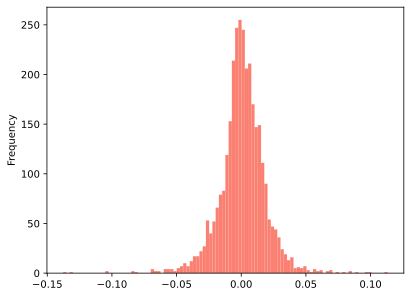

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
returns.plot.hist(bins=100, color='salmon')

La parte izquierda del gráfico muestra la frecuencia de las pérdidas (entre 8% y 6%).

Nuestro objetivo es calcular con un 95% de confianza que la mayor pérdida que podemos tener no excede de -4%. Si invertimos 100€, estamos seguros al 95% de que nuestra mayor pérdida no será mayor que 4€.

Recordemos también que Pandas ya tiene una funcion para extraer el porcentaje de cambio frente al valor anterior.

In [4]:
prices.pct_change()[:3]

Date
2010-01-04         NaN
2010-01-05    0.001729
2010-01-06   -0.015906
Name: Close, dtype: float64

### 2. Z-Score

$\displaystyle z = \frac{x - \mu}{\sigma}$

Donde $x$ es el punto de datos individual, $\mu$ es la media de la distribución y $\sigma$ la desviación estándard.

La función `ppf` devuelve un z-score que tiene el 95% de los datos por encima.

In [5]:
from scipy.stats import norm
z_score = norm.ppf(0.95) # loc:0 (µ), scale: 1 (σ)
z_score

np.float64(1.644853626951472)

### 3. Valor del portfolio el 02/01/2015

In [6]:
shares = 1000
portfolio_value = shares * prices['2015-1-02']
portfolio_value

np.float64(27332.500457763672)

### 4. Value at Risk

In [7]:
value_at_risk = portfolio_value * z_score * returns.std()
value_at_risk

np.float64(805.651959941262)

Recordemos la interpretación de qué significa ese valor: con un 95% de confianza, las pérdidas no superarían 
805.65 USD el dia siguiente. O lo que es lo mismo, un 5% de probabilidad de perder 805.65 USD.

Podemos repetir el cálculo para todos los días:

In [8]:
multiplier = (z_score * returns.std())
many_vars = (prices * shares) * multiplier
many_vars['2014-12-30': '2015-01-05']

Date
2014-12-30    829.159008
2014-12-31    813.389368
2015-01-02    805.651960
2015-01-05    782.955450
Name: Close, dtype: float64

## Method 2: Historical Data

In [9]:
def estimate_historical(returns, probability, portfolio_size):
    if (probability > 0.5):
        probability = 1 - probability
    return -(returns.quantile(probability) * portfolio_size)
    
estimate_historical(returns.dropna(), 0.05, portfolio_value)

np.float64(742.7670299400706)

Dado un tamaño de cartera de \\$27,332.50, significa que hay un 5% de probabilidad de que las pérdidas en la cartera excedan \\$742.76 dentro del horizonte de tiempo especificado.

En otras palabras, con base en datos históricos y suponiendo una distribución normal de rendimientos, existe un 5% de probabilidad de que la cartera experimente pérdidas superiores a \\$742,76.

La función primero verifica si la probabilidad proporcionada es mayor que 0.5. Si es así, la función ajusta la probabilidad restándola de 1. Esto se hace para asegurar que el cuantil utilizado para estimar el VaR corresponde a la cola inferior de la distribución. Por ejemplo, si la probabilidad original es 0.8, se ajusta a 0.2.

Otra forma similar de hacerlo sería:

In [10]:
def estimate_historical_normal_distribution(returns, probability, portfolio_size):
    if (probability > 0.5):
        probability = 1 - probability
    expected_return = returns.mean()
    std_dev = returns.std()
    return -(norm.ppf(probability, expected_return, std_dev) * portfolio_size)

estimate_historical_normal_distribution(returns.dropna(), 0.05, portfolio_value)

np.float64(780.447379974046)

## Method 3: Variance-Covariance Method
 
Given a portfolio of $P$ size with a confidence level of $c$, and considering daily returns. This method does not use actual returns, it assumes our returns data follows a normal distribution.
 
Daily VaR for a single asset is $P - (P \cdot (\alpha(1-c) + 1))$
 
Where α is the inverse of the cumulative distribution function of a normal distribution with mean μ and standard deviation σ.

In [11]:
def var_covar(P, c, mu, sigma):
    alpha = norm.ppf(1-c, mu, sigma)
    return P - P*(alpha + 1)

var_covar(portfolio_value, 0.95, returns.mean(), returns.std())

np.float64(780.4473799740445)